## 1. Imports and Functions (Run Every Time)

The following block of code consists of all of the imports and functions required to run the code in all of the sections below. Thus, this block must be run every time the kernel is restarted (important to run when first opening the document and when using Section 5).

In [1]:
### Imports

%matplotlib inline
from matplotlib import rcParams
rcParams['axes.labelsize'] = '16'
rcParams['legend.frameon'] = False
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt
import random
import sklearn
from sklearn.mixture import GaussianMixture
import warnings
from matplotlib.colors import LogNorm
import PIL
import PIL.Image
import os
from astropy.table import Table
import glob
import tensorflow as tf
import cv2
import torch
import keras
warnings.filterwarnings("ignore")

### Underlying Functions

def random_uniform_array(start,stop,size):
    values=np.zeros(size)
    for i in range(size):
        values[i]=random.uniform(start,stop)
    return values

def random_unit_vector():
    vector=random_uniform_array(-1,1,3)
    unit_vector=vector/LA.norm(vector)
    return unit_vector

def Box_Muller(N2,mu,sigma):
    N=int(N2/2)
    x1=np.random.random((N,len(mu)))
    x2=np.random.random((N,len(mu)))
    z1=np.sqrt(-2*np.log(x1))*np.cos(2*np.pi*x2)*sigma+mu
    z2=np.sqrt(-2*np.log(x1))*np.sin(2*np.pi*x2)*sigma+mu
    
    points=np.concatenate((z1,z2),axis=0)
    return points

def Generate_Points(N2,distance,node_number):
    N=int(N2/node_number)
    mu_0=np.array([0,0,0])
    sigma=random.uniform(0.1,0.5)
    
    points=Box_Muller(N,mu_0,sigma)
    
    Completed_Nodes=1

    while Completed_Nodes<node_number:
        mu=mu_0+distance*random_unit_vector()
        sigma=random.uniform(0.1,0.5)
        
        New_points=Box_Muller(N,mu,sigma)
        
        points=np.concatenate((points,New_points),axis=0)
        Completed_Nodes+=1
    return points

def Rotation_Matrix(alpha,beta,gamma): ### z, y, x / yaw, pitch, roll
    return np.array([[np.cos(alpha)*np.cos(beta),np.cos(alpha)*np.sin(beta)*np.sin(gamma)-np.sin(alpha)*np.cos(gamma),np.cos(alpha)*np.sin(beta)*np.cos(gamma)+np.sin(alpha)*np.sin(gamma)],
                     [np.sin(alpha)*np.cos(beta),np.sin(alpha)*np.sin(beta)*np.sin(gamma)+np.cos(alpha)*np.cos(gamma),np.sin(alpha)*np.sin(beta)*np.cos(gamma)-np.cos(alpha)*np.sin(gamma)],
                     [-np.sin(beta),np.cos(beta)*np.sin(gamma),np.cos(beta)*np.cos(gamma)]])

def Projected_Points(points,alpha,beta,gamma):
    projections=np.zeros(points.shape)
    R=Rotation_Matrix(alpha,beta,gamma)
    for i in range(len(points)):
        v=points[i]
        projections[i]=(R@v)
    return projections

def Test_Image(N2,distance,node_number,alpha,beta,gamma):
    points=Generate_Points(N2,distance,node_number)
    plt.rcParams["figure.figsize"]=(25/36,25/36)
    plt.hist2d(points[:,0],points[:,1],bins=(50,50),norm=LogNorm())
    plt.axis("equal")
    plt.axis("off")
    plt.show()
    
    Projections=Projected_Points(points,alpha,beta,gamma)
    plt.rcParams["figure.figsize"]=(25/36,25/36)
    plt.hist2d(Projections[:,0],Projections[:,1],bins=(50,50),norm=LogNorm())
    plt.axis("equal")
    plt.axis("off")
    plt.show()
    
def Tensor_Image(points):
    plt.rcParams["figure.figsize"]=(25/36,25/36)
    fig=plt.figure()
    plot=fig.add_subplot(111)
    plot.hist2d(points[:,0],points[:,1],bins=(50,50),norm=LogNorm())
    plot.axis("equal")
    plot.axis("off")
    fig.canvas.draw()
    w,h=fig.canvas.get_width_height()
    Image=np.fromstring(fig.canvas.tostring_argb(),dtype=np.uint8)
    Image.shape=(w,h,4)
    Image=np.roll(Image,3,axis=2)
    Tensor_Image=tf.cast(Image,tf.float32)/255
    plt.close()
    return Tensor_Image

def Save_Image_Set(Images,File_Name):
    Images=Images.numpy()
    np.save(File_Name,Images)
    
def Load_Array(File_Name):
    Images=np.load(File_Name,allow_pickle=True)        
    if type(Images[0])==np.ndarray:
        Images=tf.cast(Images,tf.float32)
    else:
        Images=tf.cast(Images,tf.string)
    return Images

def Image_Set_Classifications(N1,File_Name,classification):
    Class_Name=File_Name[:-4]+"_classifications.npy"
    classifications=np.repeat(classification,N1)
    np.save(Class_Name,classifications)
    
def Classifications_to_Labels(Data_Classifications,class_names):
    for i in range(len(class_names)):
        if Data_Classifications[0]==class_names[i]:
            Labels=tf.ones(len(Data_Classifications))*i
    return Labels

def Image_Reader(Data_Folder):
    cwd=os.getcwd()
    os.chdir(Data_Folder)
    Files=glob.glob("*.fits")
    
    File_name_0=Files[0]
    alldata_0=Table.read(File_name_0)
    xdata_0=alldata_0["pos_x"]
    ydata_0=alldata_0["pos_y"]
    zdata_0=alldata_0["pos_z"]
    
    points=np.empty((len(xdata_0),3))
    for j in range(len(xdata_0)):
        points[j]=np.array([xdata_0[j],ydata_0[j],zdata_0[j]])
        
    Data=[Tensor_Image(points)]
    
    for i in range(1,len(Files)):
        File_name=Files[i]
        alldata=Table.read(File_name)
        xdata=alldata["pos_x"]
        ydata=alldata["pos_y"]
        zdata=alldata["pos_z"]
        
        points=np.empty((len(xdata),3))
        for j in range(len(xdata)):
            points[j]=np.array([xdata[j],ydata[j],zdata[j]])
        New_Data=Tensor_Image(points)
        
        Data.append(New_Data)
    os.chdir(cwd)
    
    Data=tf.cast(Data,tf.float32)
    return Files,Data

### Primary Functions

def Image_Set_Creator(N1,N2,distance,node_number,File_Name,classification):
    points=Generate_Points(N2,distance,node_number)
    Image_0=Tensor_Image(points)
    Images=[Image_0]
    
    while len(Images)<N1:
        alpha,beta,gamma=random_uniform_array(-2*np.pi,2*np.pi,3)
        projections=Projected_Points(points,alpha,beta,gamma)
        Image=Tensor_Image(projections)
        Images.append(Image)
    Images=tf.cast(Images,tf.float32)
    Save_Image_Set(Images,File_Name)
    Image_Set_Classifications(N1,File_Name,classification)
    
def Custom_Data_Set(File_List,Set_Name):
    File_Name_0=File_List[0]
    Classification_0=File_List[0][:-4]+"_classifications.npy"
    Data_Set=Load_Array(File_Name_0)
    Data_Classifications=Load_Array(Classification_0)
    
    for i in range(1,len(File_List)):
        File_Name=File_List[i]
        Classification=File_List[i][:-4]+"_classifications.npy"
        New_Data=Load_Array(File_Name)
        New_Classifications=Load_Array(Classification)
        
        Data_Set=tf.concat((Data_Set,New_Data),axis=0)
        Data_Classifications=tf.concat((Data_Classifications,New_Classifications),axis=0)
        
    Save_Image_Set(Data_Set,Set_Name+".npy")
    Save_Image_Set(Data_Classifications,Set_Name+"_classifications.npy")

def Model_Creator(File_List,Validation_Fraction,epoch_number,class_names,classifier,save,Folder,Model_Name):
    File_Name_0=File_List[0]
    Classification_0=File_List[0][:-4]+"_classifications.npy"
    Data_Set=Load_Array(File_Name_0)
    Data_Classifications=Load_Array(Classification_0)
    Data_Labels=Classifications_to_Labels(Data_Classifications,class_names)
    
    for i in range(1,len(File_List)):
        File_Name=File_List[i]
        Classification=File_List[i][:-4]+"_classifications.npy"
        New_Data=Load_Array(File_Name)
        New_Classifications=Load_Array(Classification)
        New_Labels=Classifications_to_Labels(New_Classifications,class_names)
        
        Data_Set=tf.concat((Data_Set,New_Data),axis=0)
        Data_Labels=tf.concat((Data_Labels,New_Labels),axis=0)
        
    indices = tf.range(start=0, limit=tf.shape(Data_Set)[0], dtype=tf.int32)
    shuffled_indices = tf.random.shuffle(indices)
    
    Data_Set=tf.gather(Data_Set,shuffled_indices)
    Data_Labels=tf.gather(Data_Labels,shuffled_indices)
    
    Data_Training=Data_Set[int(Validation_Fraction*len(Data_Set)):]
    Data_Test=Data_Set[:int(Validation_Fraction*len(Data_Set))]
    
    Labels_Training=Data_Labels[int(Validation_Fraction*len(Data_Labels)):]
    Labels_Test=Data_Labels[:int(Validation_Fraction*len(Data_Labels))]
    
    Data_shape=(Data_Training.shape[1],Data_Training.shape[2],Data_Training.shape[3])
    Model=keras.Sequential()
    Model.add(keras.layers.Conv2D(16,3,padding="same",activation="relu",input_shape=Data_shape))
    Model.add(keras.layers.MaxPooling2D())
    Model.add(keras.layers.Conv2D(32,3,padding="same",activation="relu"))
    Model.add(keras.layers.MaxPooling2D())
    Model.add(keras.layers.Conv2D(64,3,padding="same",activation="relu"))
    Model.add(keras.layers.MaxPooling2D())
    Model.add(keras.layers.Flatten())
    Model.add(keras.layers.Dense(128,activation="relu"))
    Model.add(keras.layers.Dense(len(class_names)))
    Model.compile(optimizer=classifier,
                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 metrics=["accuracy"])
    Model.fit(Data_Training,Labels_Training,epochs=epoch_number,validation_data=(Data_Test,Labels_Test))
    loss,accuracy=Model.evaluate(Data_Test,Labels_Test,verbose=2)
    
    if save:
        Model.save(Folder+"/"+Model_Name)
        
def New_Image_Classifier(Data_Folder,Model_Folder,Model_Name,class_names,save,save_path,save_Folder):
    Model=tf.keras.models.load_model(Model_Folder+"/"+Model_Name,compile=True)
    Files,Data=Image_Reader(Data_Folder)
    Labels=np.argmax(Model.predict(Data),axis=1)
    Classifications=np.empty(Labels.shape,object)
    for i in range(len(Labels)):
        Classifications[i]=class_names[Labels[i]]
    Save_Data=np.array(["Predictions Made by: "+Model_Name,Files,Classifications])
    
    New_directory=str(save_path+"/"+save_Folder)
    if os.path.isdir(New_directory)==False:
        os.mkdir(New_directory)
    
    Text_File_Name=str(New_directory+"/Predictions.txt")
    NPY_File_Name=str(New_directory+"/Predictions.npy")
    np.savetxt(Text_File_Name,Save_Data,fmt="%s")
    np.save(NPY_File_Name,Save_Data)
    
def Visual_Verification(Data_Folder,save_path,save_Folder):
    New_directory=str(save_path+"/"+save_Folder)
    NPY_File_Name=str(New_directory+"/Predictions.npy")
    
    Save_Data=np.load(NPY_File_Name,allow_pickle=True)
    Model_Name=Save_Data[0][21:]
    File_List=Save_Data[1]
    Classifications=Save_Data[2]
    
    agreement=np.zeros(len(File_List),dtype=str)
    for i in range(len(File_List)):
        print(Model_Name+" gave "+File_List[i]+" the classification: "
             +Classifications[i])
        print("using this low resolution image:")
        alldata=Table.read(Data_Folder+"/"+File_List[i])
        xdata=alldata["pos_x"]
        ydata=alldata["pos_y"]
        
        plt.rcParams["figure.figsize"]=(25/36,25/36)
        plt.hist2d(xdata,ydata,bins=(50,50),norm=LogNorm())
        plt.axis("equal")
        plt.axis("off")
        plt.show()
        
        print("At full resolution, this image looks like:")
        plt.rcParams["figure.figsize"]=(6.4,4.8)
        plt.hist2d(xdata,ydata,bins=1000,norm=LogNorm())
        plt.colorbar()
        plt.show()
        agreement[i]=input("Do you agree after viewing the higher resolution image? [y/n] ")
        print("")
    Model_Accuracy=np.count_nonzero(agreement=="y")/len(agreement)
    if np.count_nonzero(agreement=="y")==len(agreement):
        print(Model_Name+" completely agrees with your classifications")
    else:
        print(Model_Name+" agrees with you to an accuracy of "+str(Model_Accuracy))
        
    Evaluations=np.zeros(len(agreement),dtype=object)
    
    for i in range(len(Evaluations)):
        if agreement[i]=="y":
            Evaluations[i]=Classifications[i]
        elif Classifications[i]=="Single Node":
            Evaluations[i]="Multiple Nodes"
        elif Classifications[i]=="Multiple Nodes":
            Evaluations[i]="Single Node"
    return Model_Accuracy,File_List,Evaluations

def Distance_Accuracy(Folder,Model_Name):
    Model=tf.keras.models.load_model(Folder+"/"+Model_Name,compile=True)
    
    class_names=["Single Node","Multiple Nodes"]
    dvals=["dvals=",0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7,7.5,8,8.5,9,9.5,10]
    for node_number in range(1,11):
        Accuracies=["Accuracies="]
        Losses=["Losses="]
        for i in range(1,len(dvals)):
            if node_number==1:
                File_Name="Projection_Method_Image_Sets/Single_node_d"+str(dvals[i])+"_10k.npy"
            else:
                File_Name="Projection_Method_Image_Sets/"+str(node_number)+"nodes_d"+str(dvals[i])+"_10k.npy"
            Data_Test=Load_Array(File_Name)
            Classifications=Load_Array(File_Name[:-4]+"_classifications.npy")
            Labels_Test=Classifications_to_Labels(Classifications,class_names)
            Loss,Accuracy=Model.evaluate(Data_Test,Labels_Test,verbose=2)
            Accuracies.append(Accuracy)
            Losses.append(Loss)
    
        Directory=str(Folder+"/"+Model_Name+"_Parameters/")
        Textfile_Data=np.array([dvals,Losses,Accuracies],dtype=object)
        if node_number==1:
            Name=str(Directory+Model_Name+"_Single_node_Accuracy.txt")
            NPY_Name=str(Directory+Model_Name+"_Single_node_Accuracy.npy")
        else:
            Name=str(Directory+Model_Name+"_"+str(node_number)+"nodes_Accuracy.txt")
            NPY_Name=str(Directory+Model_Name+"_"+str(node_number)+"nodes_Accuracy.npy")
        np.savetxt(Name,Textfile_Data,fmt="%s")
        np.save(NPY_Name,Textfile_Data)
    
def Distance_Accuracy_Plot(Folder,Model_Name):
    plt.rcParams["figure.figsize"]=(5,5)
    Directory=str(Folder+"/"+Model_Name+"_Parameters/")
    for node_number in range(1,11):
        if node_number==1:
            NPY_Name=str(Directory+Model_Name+"_Single_node_Accuracy.npy")
            dvals,Losses,Accuracies=np.load(NPY_Name,allow_pickle=True)
            plt.plot(dvals[1:],Accuracies[1:],label="Single Node")
        else:
            NPY_Name=str(Directory+Model_Name+"_"+str(node_number)+"nodes_Accuracy.npy")
            dvals,Losses,Accuracies=np.load(NPY_Name,allow_pickle=True)
            plt.plot(dvals[1:],Accuracies[1:],label=(str(node_number)+" Nodes"))
        plt.ylim(-0.05,1.05)
        plt.xlabel("Distance",size=17)
        plt.ylabel("Accuracy",size=17)
        plt.legend()
        plt.show()

## 2. Test Images

Use the following code to create test images, which will not be saved. The variables "N2," "distance," and "node_number" are parameters used in image generation. Respectively, they describe the ammount of points generated, the distance between the nodes, and the number of nodes that are truly present. The variables "alpha," "beta," and "gamma" are angle parameters used to view the same points from a new orientation described by the yaw-pitch-roll scheme (effectively a new randomly generated image).

In [ ]:
N2=1000
distance=2
node_number=2

alpha=1
beta=1
gamma=0.5

Test_Image(N2,distance,node_number,alpha,beta,gamma)

## 3. Image Set Creator

Use the following code to create and save numpy arrays consisting of images randomly generated using many of the same parameters as Section 2. The new variables "N1," "File_Name," and "classification" do not affect the appearance of any generated images. Instead, they describe the number of images being generated, the name of the file being written, and the classification being given to each image in the set. Before running, select an appropriate file name (one representative of the parameters chosen) and check that the appropriate classification is selected (apply "Single Node" if node_number=1 and "Multiple Nodes" if node_number>1).

In [ ]:
N1=10000
N2=1000
distance=10
node_number=9
File_Name="Projection_Method_Image_Sets/9nodes_d10_10k.npy"
#classification="Single Node"
classification="Multiple Nodes"

Image_Set_Creator(N1,N2,distance,node_number,File_Name,classification)

## 4. Model Creator

Use the following code to create and train an image classification model. This section implements an entirely new set of variables. "File_List" refers to the selection of files used to train the model (approximate maximum of 200000 total images due to memory limitations); "Validation_Fraction" refers to the percentage of total data assigned to test the accuracy of the final model; "epoch_number" refers to the number of epochs that will occur during the model training; "class_names" represents the list of total classifications present (in this case, it will always remain "Single Node" and "Multiple Nodes"); "classifier" refers the algorithm used for training the model (see https://www.tensorflow.org/api_docs/python/tf/keras/optimizers and look under "Classes" for more options); "save" represents the option to save the model that has just been created, set "True" to record the trained model or "False" if you do not want it to be saved; "Folder" refers to the directory to which the model can be saved (externally created); and Model_Name refers to the name given to the model if it is saved (It will appear as a new folder in the directory chosen for saved models).

In [ ]:
File_List=["Projection_Method_Image_Sets/Single_node_d5.5_10k.npy",
           "Projection_Method_Image_Sets/Single_node_d6_10k.npy",
           "Projection_Method_Image_Sets/Single_node_d6.5_10k.npy",
           "Projection_Method_Image_Sets/Single_node_d7_10k.npy",
           "Projection_Method_Image_Sets/Single_node_d7.5_10k.npy",
           "Projection_Method_Image_Sets/Single_node_d8_10k.npy",
           "Projection_Method_Image_Sets/Single_node_d8.5_10k.npy",
           "Projection_Method_Image_Sets/Single_node_d9_10k.npy",
           "Projection_Method_Image_Sets/Single_node_d9.5_10k.npy",
           "Projection_Method_Image_Sets/Single_node_d10_10k.npy",
           "Projection_Method_Image_Sets/2nodes_d0.5_10k.npy",
           "Projection_Method_Image_Sets/2nodes_d1_10k.npy",
           "Projection_Method_Image_Sets/4nodes_d0.5_10k.npy",
           "Projection_Method_Image_Sets/4nodes_d1_10k.npy",
           "Projection_Method_Image_Sets/6nodes_d0.5_10k.npy",
           "Projection_Method_Image_Sets/6nodes_d1_10k.npy",
           "Projection_Method_Image_Sets/8nodes_d0.5_10k.npy",
           "Projection_Method_Image_Sets/8nodes_d1_10k.npy",
           "Projection_Method_Image_Sets/10nodes_d0.5_10k.npy",
           "Projection_Method_Image_Sets/10nodes_d1_10k.npy"]
Validation_Fraction=0.2
epoch_number=50
class_names=["Single Node","Multiple Nodes"]
classifier="SGD"
save=True
Folder="Saved_Models"
Model_Name="Model_15"


Model_Creator(File_List,Validation_Fraction,epoch_number,class_names,classifier,save,Folder,Model_Name)

## 5.1 Model Accuracy Evaluations - Node Dependence

Use the following code to test the accuracy of the models created in Section 4. In the first block, record the loss and accuracy terms provided by the internal evaluation from training a model. In the next, record the same parameters used for the model's creation (block above if the desired model has just been created). Running the rest of the blocks will test the accuracy of the selected model against custom datasets I have previously created. Each set consists of 200000 images generated using the same amount of nodes, but spanning 20 values of distance (starting at 0.5 and ending at 10, with intervals of 0.5). Unfortunately, due to the size of these data sets, the kernel dies frequently and the following code cannot be looped as of now. Thus, it becomes necessary to record the printed statements manually and restart the kernel before assessing a new set of data corresponding to a new node value. Each time after restarting the kernel, run Section 1 and the block which loads in the model (2 below). After the accuracy has been evaluated at all node values, run the manually recorded values for loss and accuracy for each node value (and for the original model, which is recorded directly below). After this process is completed, the final block will create a new folder in the same location as the model and with a similar name (adding "_Parameters" after the original model name). This folder will contain an overview of the accuracy of the model and a record of the parameters used in its creation using a .txt file and .npy file for easy viewing and further manipulation respectively.

In [ ]:
#From Print Statements
Loss,Accuracy=0.0434,0.9910

In [ ]:
File_List=["Projection_Method_Image_Sets/Single_node_d5.5_10k.npy",
           "Projection_Method_Image_Sets/Single_node_d6_10k.npy",
           "Projection_Method_Image_Sets/Single_node_d6.5_10k.npy",
           "Projection_Method_Image_Sets/Single_node_d7_10k.npy",
           "Projection_Method_Image_Sets/Single_node_d7.5_10k.npy",
           "Projection_Method_Image_Sets/Single_node_d8_10k.npy",
           "Projection_Method_Image_Sets/Single_node_d8.5_10k.npy",
           "Projection_Method_Image_Sets/Single_node_d9_10k.npy",
           "Projection_Method_Image_Sets/Single_node_d9.5_10k.npy",
           "Projection_Method_Image_Sets/Single_node_d10_10k.npy",
           "Projection_Method_Image_Sets/2nodes_d0.5_10k.npy",
           "Projection_Method_Image_Sets/2nodes_d1_10k.npy",
           "Projection_Method_Image_Sets/4nodes_d0.5_10k.npy",
           "Projection_Method_Image_Sets/4nodes_d1_10k.npy",
           "Projection_Method_Image_Sets/6nodes_d0.5_10k.npy",
           "Projection_Method_Image_Sets/6nodes_d1_10k.npy",
           "Projection_Method_Image_Sets/8nodes_d0.5_10k.npy",
           "Projection_Method_Image_Sets/8nodes_d1_10k.npy",
           "Projection_Method_Image_Sets/10nodes_d0.5_10k.npy",
           "Projection_Method_Image_Sets/10nodes_d1_10k.npy"]
Validation_Fraction=0.2
epoch_number=50
class_names=["Single Node","Multiple Nodes"]
classifier="SGD"
save=True
Folder="Saved_Models"
Model_Name="Model_15"


Model=tf.keras.models.load_model(Folder+"/"+Model_Name,compile=True)

In [ ]:
Data_Test=Load_Array("Projection_Method_Image_Sets/Accuracy_Check_Single_node.npy")
Classifications=Load_Array("Projection_Method_Image_Sets/Accuracy_Check_Single_node_classifications.npy")
Labels_Test=Classifications_to_Labels(Classifications,class_names)
Single_Node_Loss,Single_Node_Accuracy=Model.evaluate(Data_Test,Labels_Test,verbose=2)
    
del(Data_Test,Classifications,Labels_Test)

In [ ]:
#From Print Statements
Single_Node_Loss,Single_Node_Accuracy=0.0399,0.9912

In [ ]:
Data_Test=Load_Array("Projection_Method_Image_Sets/Accuracy_Check_2nodes.npy")
Classifications=Load_Array("Projection_Method_Image_Sets/Accuracy_Check_2nodes_classifications.npy")
Labels_Test=Classifications_to_Labels(Classifications,class_names)
Two_Node_Loss,Two_Node_Accuracy=Model.evaluate(Data_Test,Labels_Test,verbose=2)
    
del(Data_Test,Classifications,Labels_Test)

In [ ]:
#From Print Statements
Two_Node_Loss,Two_Node_Accuracy=0.0385,0.9967

In [ ]:
Data_Test=Load_Array("Projection_Method_Image_Sets/Accuracy_Check_3nodes.npy")
Classifications=Load_Array("Projection_Method_Image_Sets/Accuracy_Check_3nodes_classifications.npy")
Labels_Test=Classifications_to_Labels(Classifications,class_names)
Three_Node_Loss,Three_Node_Accuracy=Model.evaluate(Data_Test,Labels_Test,verbose=2)
    
del(Data_Test,Classifications,Labels_Test)

In [ ]:
#From Print Statements
Three_Node_Loss,Three_Node_Accuracy=0.2903,0.9711

In [ ]:
Data_Test=Load_Array("Projection_Method_Image_Sets/Accuracy_Check_4nodes.npy")
Classifications=Load_Array("Projection_Method_Image_Sets/Accuracy_Check_4nodes_classifications.npy")
Labels_Test=Classifications_to_Labels(Classifications,class_names)
Four_Node_Loss,Four_Node_Accuracy=Model.evaluate(Data_Test,Labels_Test,verbose=2)
    
del(Data_Test,Classifications,Labels_Test)

In [ ]:
#From Print Statements
Four_Node_Loss,Four_Node_Accuracy=2.3948e-07,1.0000

In [ ]:
Data_Test=Load_Array("Projection_Method_Image_Sets/Accuracy_Check_5nodes.npy")
Classifications=Load_Array("Projection_Method_Image_Sets/Accuracy_Check_5nodes_classifications.npy")
Labels_Test=Classifications_to_Labels(Classifications,class_names)
Five_Node_Loss,Five_Node_Accuracy=Model.evaluate(Data_Test,Labels_Test,verbose=2)
    
del(Data_Test,Classifications,Labels_Test)

In [ ]:
#From Print Statements
Five_Node_Loss,Five_Node_Accuracy=1.2177e-04,1.0000

In [ ]:
Data_Test=Load_Array("Projection_Method_Image_Sets/Accuracy_Check_6nodes.npy")
Classifications=Load_Array("Projection_Method_Image_Sets/Accuracy_Check_6nodes_classifications.npy")
Labels_Test=Classifications_to_Labels(Classifications,class_names)
Six_Node_Loss,Six_Node_Accuracy=Model.evaluate(Data_Test,Labels_Test,verbose=2)
    
del(Data_Test,Classifications,Labels_Test)

In [ ]:
#From Print Statements
Six_Node_Loss,Six_Node_Accuracy=0.0010,0.9998

In [ ]:
Data_Test=Load_Array("Projection_Method_Image_Sets/Accuracy_Check_7nodes.npy")
Classifications=Load_Array("Projection_Method_Image_Sets/Accuracy_Check_7nodes_classifications.npy")
Labels_Test=Classifications_to_Labels(Classifications,class_names)
Seven_Node_Loss,Seven_Node_Accuracy=Model.evaluate(Data_Test,Labels_Test,verbose=2)
    
del(Data_Test,Classifications,Labels_Test)

In [ ]:
#From Print Statements
Seven_Node_Loss,Seven_Node_Accuracy=0.0202,0.9960

In [ ]:
Data_Test=Load_Array("Projection_Method_Image_Sets/Accuracy_Check_8nodes.npy")
Classifications=Load_Array("Projection_Method_Image_Sets/Accuracy_Check_8nodes_classifications.npy")
Labels_Test=Classifications_to_Labels(Classifications,class_names)
Eight_Node_Loss,Eight_Node_Accuracy=Model.evaluate(Data_Test,Labels_Test,verbose=2)

del(Data_Test,Classifications,Labels_Test)

In [ ]:
#From Print Statements
Eight_Node_Loss,Eight_Node_Accuracy=0.0018,0.9997

In [ ]:
Data_Test=Load_Array("Projection_Method_Image_Sets/Accuracy_Check_9nodes.npy")
Classifications=Load_Array("Projection_Method_Image_Sets/Accuracy_Check_9nodes_classifications.npy")
Labels_Test=Classifications_to_Labels(Classifications,class_names)
Nine_Node_Loss,Nine_Node_Accuracy=Model.evaluate(Data_Test,Labels_Test,verbose=2)

del(Data_Test,Classifications,Labels_Test)

In [ ]:
#From Print Statements
Nine_Node_Loss,Nine_Node_Accuracy=0.1274,0.9858

In [ ]:
Data_Test=Load_Array("Projection_Method_Image_Sets/Accuracy_Check_10nodes.npy")
Classifications=Load_Array("Projection_Method_Image_Sets/Accuracy_Check_10nodes_classifications.npy")
Labels_Test=Classifications_to_Labels(Classifications,class_names)
Ten_Node_Loss,Ten_Node_Accuracy=Model.evaluate(Data_Test,Labels_Test,verbose=2)

del(Data_Test,Classifications,Labels_Test)

In [ ]:
#From Print Statements
Ten_Node_Loss,Ten_Node_Accuracy=0.0027,0.9995

In [ ]:
parameters=["Validation_Fraction=",Validation_Fraction,
            "epoch_number=",epoch_number,
            "classifier=",classifier]

Losses=["Loss=",Loss,
        "Single_Node_Loss=",Single_Node_Loss,
        "Two_Node_Loss=",Two_Node_Loss,
        "Three_Node_Loss=",Three_Node_Loss,
        "Four_Node_Loss=",Four_Node_Loss,
        "Five_Node_Loss=",Five_Node_Loss,
        "Six_Node_Loss=",Six_Node_Loss,
        "Seven_Node_Loss=",Seven_Node_Loss,
        "Eight_Node_Loss=",Eight_Node_Loss,
        "Nine_Node_Loss=",Nine_Node_Loss,
        "Ten_Node_Loss=",Ten_Node_Loss]


Accuracies=["Accuracy=",Accuracy,
            "Single_Node_Accuracy=",Single_Node_Accuracy,
            "Two_Node_Accuracy=",Two_Node_Accuracy,
            "Three_Node_Accuracy=",Three_Node_Accuracy,
            "Four_Node_Accuracy=",Four_Node_Accuracy,
            "Five_Node_Accuracy=",Five_Node_Accuracy,
            "Six_Node_Accuracy=",Six_Node_Accuracy,
            "Seven_Node_Accuracy=",Seven_Node_Accuracy,
            "Eight_Node_Accuracy=",Eight_Node_Accuracy,
            "Nine_Node_Accuracy=",Nine_Node_Accuracy,
            "Ten_Node_Accuracy=",Ten_Node_Accuracy]

New_directory=str(Folder+"/"+Model_Name+"_Parameters/")
if os.path.isdir(New_directory)==False:
        os.mkdir(New_directory)
    
Textfile_Data=np.array([File_List,parameters,Losses,Accuracies],dtype=object)
Name=str(New_directory+Model_Name+"_Overview.txt")
np.savetxt(Name,Textfile_Data,fmt="%s")
NPY_Name=str(New_directory+Model_Name+"_Overview.npy")
np.save(NPY_Name,Textfile_Data)

## 5.2 Model Accuracy Evaluations - Distance Dependence

In [2]:
Folder="Saved_Models"
Model_Name="Model_15"

Distance_Accuracy(Folder,Model_Name)

313/313 - 2s - loss: 0.0486 - accuracy: 0.9894
313/313 - 1s - loss: 0.0484 - accuracy: 0.9882
313/313 - 1s - loss: 0.2659 - accuracy: 0.9473
313/313 - 1s - loss: 0.0174 - accuracy: 0.9948
313/313 - 1s - loss: 0.1954 - accuracy: 0.9587
313/313 - 1s - loss: 0.0660 - accuracy: 0.9864
313/313 - 1s - loss: 0.0286 - accuracy: 0.9915
313/313 - 1s - loss: 0.0160 - accuracy: 0.9950
313/313 - 1s - loss: 0.0119 - accuracy: 0.9965
313/313 - 2s - loss: 0.0409 - accuracy: 0.9903
313/313 - 1s - loss: 0.0089 - accuracy: 0.9977
313/313 - 1s - loss: 0.0015 - accuracy: 0.9995
313/313 - 1s - loss: 0.0012 - accuracy: 0.9997
313/313 - 1s - loss: 0.0081 - accuracy: 0.9974
313/313 - 1s - loss: 0.0089 - accuracy: 0.9979
313/313 - 1s - loss: 0.0084 - accuracy: 0.9978
313/313 - 1s - loss: 0.0046 - accuracy: 0.9989
313/313 - 1s - loss: 0.0034 - accuracy: 0.9994
313/313 - 1s - loss: 0.0017 - accuracy: 0.9995
313/313 - 1s - loss: 0.0126 - accuracy: 0.9976
313/313 - 1s - loss: 0.0015 - accuracy: 0.9996
313/313 - 1s 

313/313 - 1s - loss: 0.0000e+00 - accuracy: 1.0000
313/313 - 1s - loss: 0.0000e+00 - accuracy: 1.0000
313/313 - 1s - loss: 0.0000e+00 - accuracy: 1.0000
313/313 - 1s - loss: 0.0000e+00 - accuracy: 1.0000
313/313 - 1s - loss: 3.5763e-11 - accuracy: 1.0000
313/313 - 1s - loss: 0.0000e+00 - accuracy: 1.0000
313/313 - 1s - loss: 0.0000e+00 - accuracy: 1.0000
313/313 - 1s - loss: 1.1921e-11 - accuracy: 1.0000
313/313 - 1s - loss: 2.3842e-11 - accuracy: 1.0000
313/313 - 1s - loss: 0.0000e+00 - accuracy: 1.0000
313/313 - 1s - loss: 5.9605e-11 - accuracy: 1.0000
313/313 - 1s - loss: 9.4225e-08 - accuracy: 1.0000
313/313 - 1s - loss: 2.1458e-10 - accuracy: 1.0000
313/313 - 1s - loss: 2.7418e-10 - accuracy: 1.0000
313/313 - 1s - loss: 0.0000e+00 - accuracy: 1.0000
313/313 - 1s - loss: 0.0540 - accuracy: 0.9902
313/313 - 1s - loss: 7.4179e-07 - accuracy: 1.0000
313/313 - 1s - loss: 0.0000e+00 - accuracy: 1.0000
313/313 - 1s - loss: 0.0000e+00 - accuracy: 1.0000
313/313 - 1s - loss: 0.0000e+00 - a

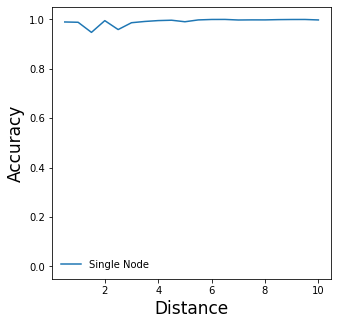

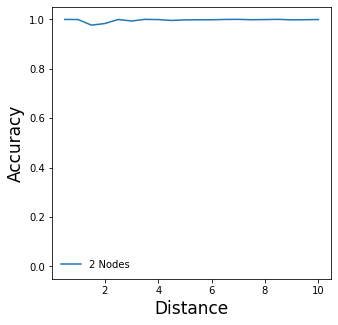

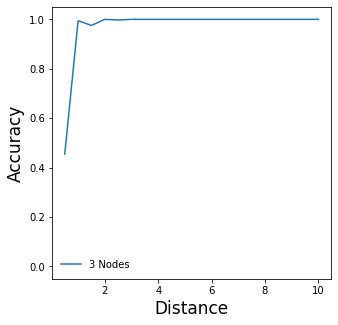

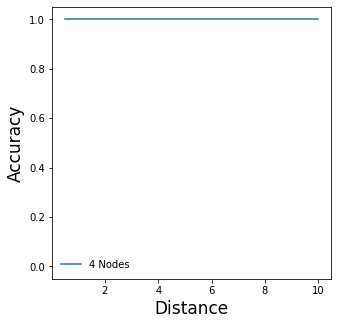

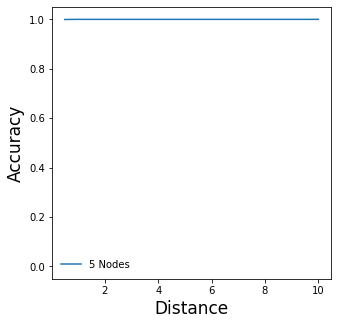

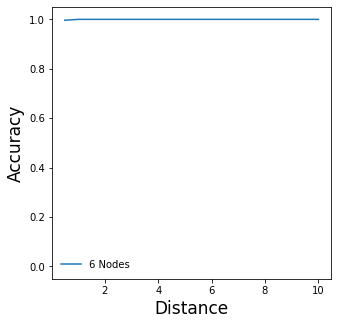

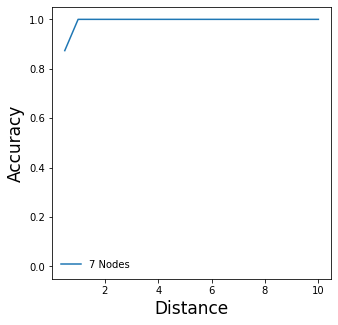

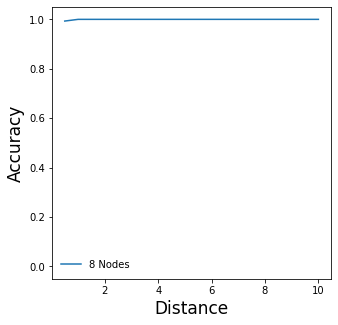

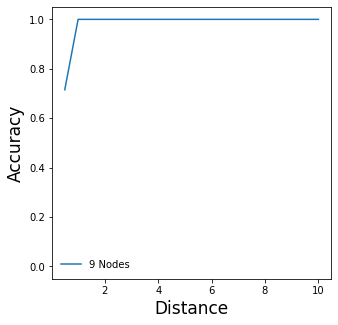

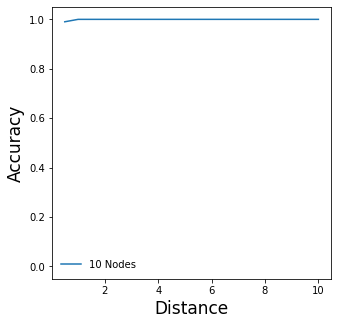

In [3]:
Folder="Saved_Models"
Model_Name="Model_15"

Distance_Accuracy_Plot(Folder,Model_Name)     

## 6. New Image Predictions

In running this code, fits files from other sources are evaluated by a model and given either the classification of "Single Node" or "Multiple Nodes." Important data will be saved as a .txt file for easy viewing as well as a .npy file to be easily loaded into python notebooks. The final block also introduces new variables used to specify the original folder containing the fits files to be evaluated and the final location for saving the predictions that the model makes. More specifically, "Data_Folder" refers to the folder of input data / externally obtained fits files (Note: every file ending in .fits contained in the provided folder will be evaluated); "Model_Folder" refers to the directory that contains the model selected to make the evaluations; "save_path" refers to the directory in which saved evaluations will be stored; "save_Folder" refers to the name given to the folder storing the .txt and .npy outputs.

In [4]:
Data_Folder="/nfs/Christoq1/mccleve/TestSet"
Model_Folder="/nfs/Christoq1/mccleve/Machine Learning Project/Image_Classification_Projection_Method/Saved_Models"
Model_Name="Model_15"
class_names=["Single Node","Multiple Nodes"]
save=True
save_path="/nfs/Christoq1/mccleve/Machine Learning Project/Image_Classification_Projection_Method/New_Image_Predictions"
save_Folder="Test_Set_15"

New_Image_Classifier(Data_Folder,Model_Folder,Model_Name,class_names,save,save_path,save_Folder)

## 7. Visual Verification

The following code will visually display the name of the fits files as well as the classification given by the model. This is used to further assess the accuracy of the model by comparison to human evaluation of the images. This code utilizes "Data_Folder" and the saving inputs used in the previous block to access the predictions made in the previous section (Note: Nothing is actually being saved in this section, the variable names only appear this way for internal consistency). Running this code will display the name of the file being accessed, the classification given by the model, and the low resolution image that the model used. At this point, the full resolution image will be plotted and the user will be asked if they agree with the classification made by the model. Based on the decisions made by the user ("y" or "n"), the code will keep track of the correct classifications according to the user. This information can be accessed at the end of the process (only after viewing all of the images contained in "Data_Folder") using the "Evaluations" output array. After all of the images have been displayed and given user input, the user will be notified of the model's accuracy.

In [ ]:
Data_Folder="/nfs/Christoq1/mccleve/TestSet"
save_path="/nfs/Christoq1/mccleve/Machine Learning Project/Image_Classification_Projection_Method/New_Image_Predictions"
save_Folder="Test_Set_2"

Model_Accuracy,File_List,Evaluations=Visual_Verification(Data_Folder,save_path,save_Folder)

In [ ]:
Model_Accuracy,File_List,Evaluations